In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
import torch.utils.data as data
import zuko

import sys
import importlib
sys.path.append(r'D:\Code\MRI\MaxEnt')
import Basic_functions
importlib.reload(Basic_functions)
from Basic_functions import Cartesian, kernel, forward_operator, get_Sqs

In [49]:

def f_given_parameters(thetas, parameters, modes = 1):
    """
    thetas: which is a matrix of size (n, 2)
    parameters: which is a vector of size (6 * modes,)
    """
    if len(parameters) != modes * 6:
        raise ValueError("Parameters should be of length modes * 6")
    
    mu_x = parameters[:modes]
    mu_y = parameters[modes:2*modes]
    sigma_x = parameters[2*modes:3*modes]
    sigma_y = parameters[3*modes:4*modes]
    rho = parameters[4*modes:5*modes]
    weights = parameters[5*modes:]

    f_thetas = np.zeros(thetas.shape[0])
    for i in range(modes):
        mean = [mu_x[i], mu_y[i]]
        cov = [ [sigma_x[i]**2, rho[i]*sigma_x[i]*sigma_y[i]],
                [rho[i]*sigma_x[i]*sigma_y[i], sigma_y[i]**2]   ]

        MultiNormal = multivariate_normal(mean=mean, cov=cov)
        f_thetas += weights[i] * MultiNormal.pdf(thetas)
    
    return f_thetas

def synthetic_f(theta1, theta2, modes = 1):

    thetas, _ = Cartesian(theta1, theta2)
    

    mu_x = np.empty(modes)
    mu_y = np.empty(modes)
    sigma_x = np.empty(modes)
    sigma_y = np.empty(modes)
    rho = np.empty(modes)
    weights = np.random.dirichlet([1]* modes)

    for i in range(modes):
        while True:
            mu_x[i] = np.random.uniform(np.min(theta1), np.max(theta1))
            mu_y[i] = np.random.uniform(np.min(theta2), np.max(theta2))
            sigma_x[i] = np.random.uniform(0.05, np.max(theta1)/6)
            sigma_y[i] = np.random.uniform(1, np.max(theta2)/6)
            rho[i] = np.random.uniform(-0.9, 0.9)

            if (mu_x[i] + 3*sigma_x[i] < np.max(theta1) and 
                mu_x[i] - 3*sigma_x[i] > np.min(theta1) and 
                mu_y[i] + 3*sigma_y[i] < np.max(theta2) and 
                mu_y[i] - 3*sigma_y[i] > np.min(theta2)):
                break

    idx = np.argsort(mu_x) # sort by mu_x!!!!
    mu_x = mu_x[idx]
    mu_y = mu_y[idx]
    sigma_x = sigma_x[idx]
    sigma_y = sigma_y[idx]
    rho = rho[idx]
    weights = weights[idx]

    parameters = np.concatenate([mu_x, mu_y, sigma_x, sigma_y, rho, weights])

    f_thetas = f_given_parameters(thetas, parameters, modes)
    
    return f_thetas, parameters

def synthetic_Sqs(q1, q2, theta1, theta2, f_thetas, sigma = 0):
    ## This function generates a synthetic Sqs given the designed qs
    qs, _ = Cartesian(q1, q2)
    thetas, weights = Cartesian(theta1, theta2)
    Sqs = get_Sqs(qs, thetas, weights, f_thetas, sigma = sigma)
    return qs, Sqs


### Plot

In [50]:
def compare_contour(theta1, theta2, samples, f_true):
    ## This is a plotting function to visualize the results of the recovered density function and the recoveredS(q)
    """
    theta1: which is a vector of size (n1,)
    theta2: which is a vector of size (n2,)
    """
    theta11, theta22 = np.meshgrid(theta1, theta2)
    f_true_reshape = f_true.reshape(theta11.shape, order='F')

    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    contourplot = axs[0].contourf(theta11, theta22, f_true_reshape, levels=50, cmap='viridis')
    axs[0].set_xlabel(r'D (${\mu m}^2/ms$)')
    axs[0].set_ylabel(r'R ($s^{-1}$)')
    axs[0].set_title('True')
    plt.colorbar(contourplot, ax=axs[0])

    xy = np.vstack([samples[:,0], samples[:,1]])
    kde = gaussian_kde(xy)
    Z = kde(np.vstack([theta11.ravel(), theta22.ravel()])).reshape(theta11.shape)

    true_contour = axs[1].contourf(theta11, theta22, Z, levels=50, cmap='viridis')
    axs[1].set_xlabel(r'D (${\mu m}^2/ms$)')
    axs[1].set_ylabel(r'R ($s^{-1}$)')
    axs[1].set_title('Recovered')
    plt.colorbar(true_contour, ax=axs[1])

    plt.show()

### Training Data

In [79]:
q1 = np.linspace(0, 3.5, 4)
q2 = np.linspace(0.05, 0.2, 5)
qs, _ = Cartesian(q1, q2)

theta1 = np.linspace(0, 2, 40)
theta2 = np.linspace(0, 100, 40)
thetas, weights = Cartesian(theta1, theta2)

number = 128
Sqs = np.zeros((number, qs.shape[0]))
f_thetas = np.zeros((number, thetas.shape[0]))

for i in range(number):
    f_thetas[i,:], _ = synthetic_f(theta1, theta2, modes = np.random.randint(1, 3))
    _, Sqs[i, :] = synthetic_Sqs(q1, q2, theta1, theta2, f_thetas[i,:], sigma = 0)

Sqs_torch = torch.tensor(Sqs, dtype=torch.float32).repeat(  len(theta1)*len(theta2) , 1)
f_thetas_torch = torch.tensor(np.reshape(f_thetas, (-1, 1), order='F'), dtype=torch.float32)
thetas_torch = torch.tensor(np.repeat(thetas, repeats= number, axis=0), dtype=torch.float32)

trainset = data.TensorDataset(thetas_torch, f_thetas_torch, Sqs_torch)
trainloader = data.DataLoader(trainset, batch_size = 64, shuffle=True)


### Model

In [80]:
flow = zuko.flows.MAF(features = 2, context = len(q1) * len(q2), transforms=8, hidden_features=[128, 128])
optimizer = Adam(flow.parameters(), lr=1e-2)

for epoch in range(10):

    losses = []

    for thetas_batch, f_thetas_batch, Sqs_batch in trainloader:

        dist = flow(Sqs_batch)
        f_hat = torch.empty(thetas_batch.shape[0], 1)

        f_hat[:, 0] = dist.log_prob(thetas_batch).exp()

        loss = torch.mean((f_hat - f_thetas_batch)**2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())

    if (epoch+1) % 1 == 0:
        print(f"Finished: {epoch+1}, L2 Loss: {np.array(losses).mean():.6f}")


Finished: 1, L2 Loss: 0.000877
Finished: 2, L2 Loss: 0.000877
Finished: 3, L2 Loss: 0.000877
Finished: 4, L2 Loss: 0.000877
Finished: 5, L2 Loss: 0.000877
Finished: 6, L2 Loss: 0.000877
Finished: 7, L2 Loss: 0.000877
Finished: 8, L2 Loss: 0.000877
Finished: 9, L2 Loss: 0.000877
Finished: 10, L2 Loss: 0.000877


### Test

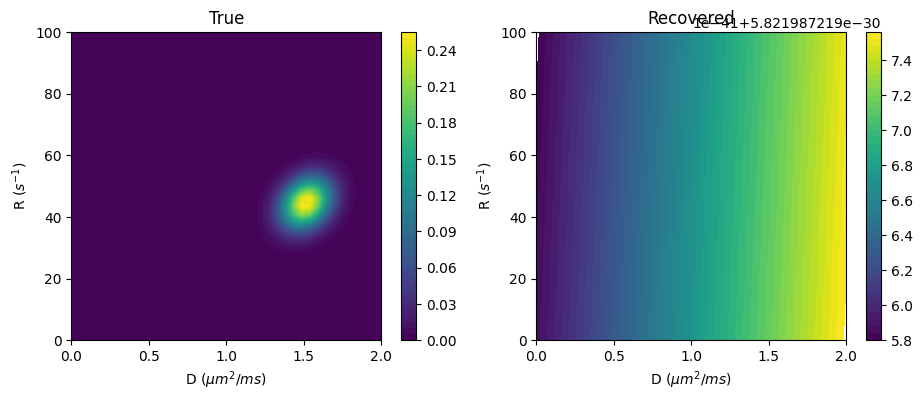

In [82]:
f_thetas_test, _ = synthetic_f(theta1, theta2, modes=np.random.choice([1,2]))
_, Sqs_test = synthetic_Sqs(q1, q2, theta1, theta2, f_thetas_test)


# Prepare test input
Sqs_test_torch = torch.tensor(Sqs_test, dtype=torch.float32).unsqueeze(0) 

# Sample predicted results from the trained flow
flow.eval()
with torch.no_grad():
    dist = flow(Sqs_test_torch)                   
    samples = dist.rsample((10000,)).squeeze().numpy()

# Compare the true and predicted density functions
compare_contour(theta1, theta2, samples, f_thetas_test)
